<a href="https://colab.research.google.com/github/zlakcswair/Python_Evaluaciones_202520/blob/main/Evaluaci%C3%B3n_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Evaluación 4 Python aplicado a la Ingeniería 202520

Docente: Miguel Ortiz Padilla

Estudiantes: Wilmer David jiménez Díaz, Santiago Ibarra Méndez, Tobías Lozano Florez

e-mails: wilmer.jimenez@upb.edu.co,
         santiago.ibarra@upb.edu.co,
         tobias.lozano@upb.edu.co

Fecha: 09/24/2025


RESUMEN: El Cairo (2022)
RADIACIÓN SOLAR:
  • Promedio diario: 242.87 W/m²
  • Promedio mensual: 242.58 W/m²
  • Promedio anual: 242.87 W/m²

VALORES EXTREMOS:
  • Máxima radiación: 2022-07-06 11:30:00 -> 1042.0 W/m²
  • Mínima radiación: 2022-01-01 00:30:00 -> 0.0 W/m²

ENERGÍA DISPONIBLE:
  • Anual: 2127542 Wh/m² (2127.5 kWh/m²)
  • Diaria promedio: 5829 Wh/m²
  • Diaria máxima: 8558 Wh/m²
  • Diaria mínima: 413 Wh/m²

VARIACIÓN ESTACIONAL MENSUAL:
Mes  GHI_promedio (W/m²)  Energía_mes (kWh/m²)
Ene               115.88                 86.22
Feb               177.83                119.50
Mar               228.69                170.14
Abr               278.86                200.78
May               314.04                233.64
Jun               339.67                244.56
Jul               341.43                254.02
Ago               309.18                230.03
Sep               270.26                194.59
Oct               217.32                161.69
Nov               168.72   

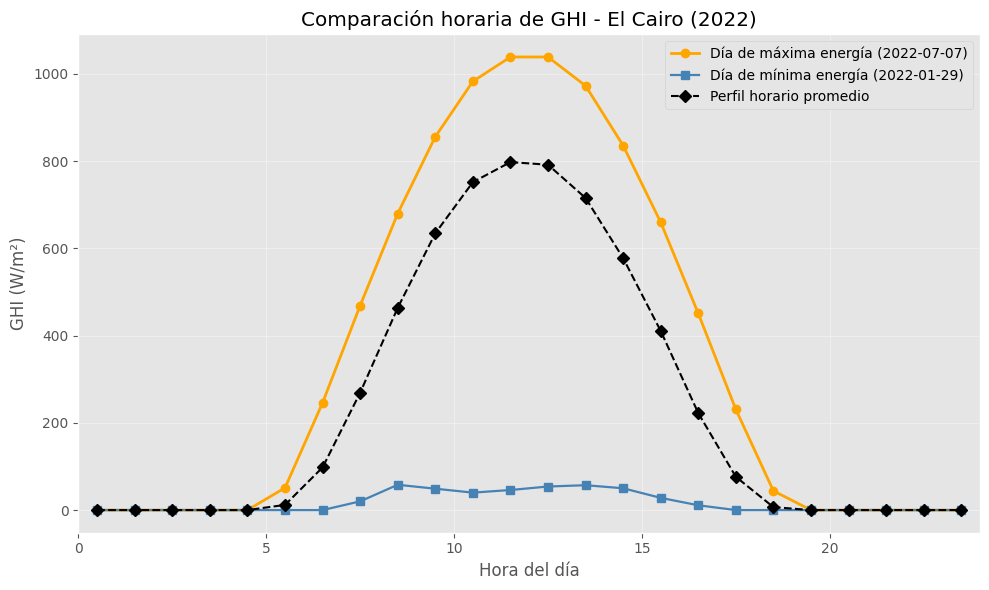

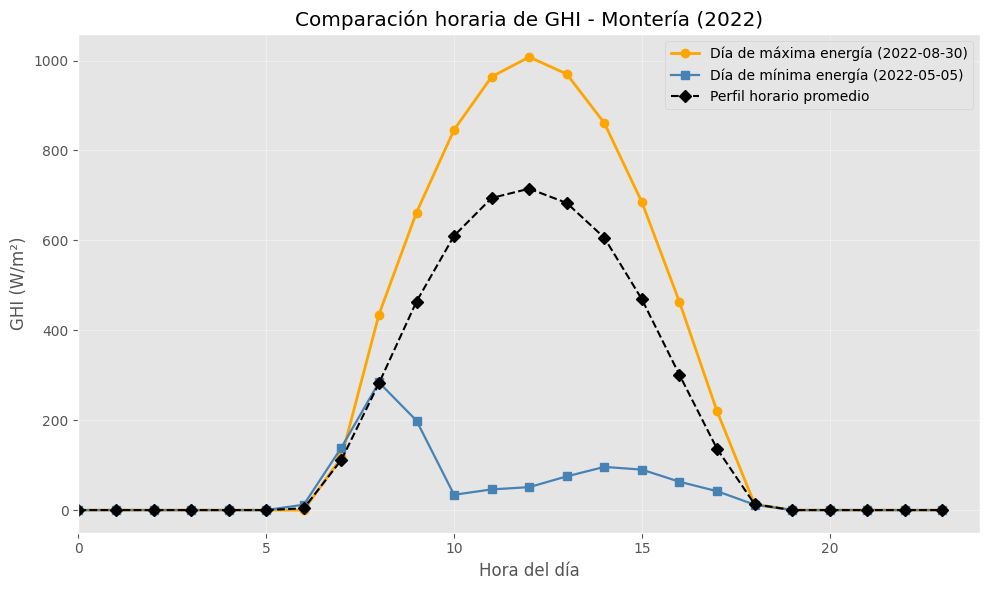

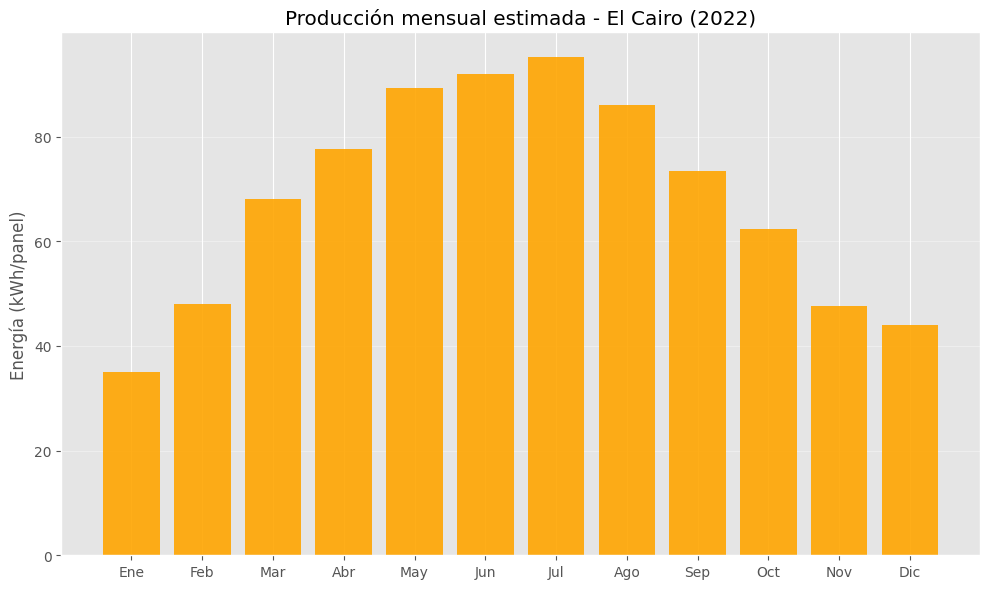

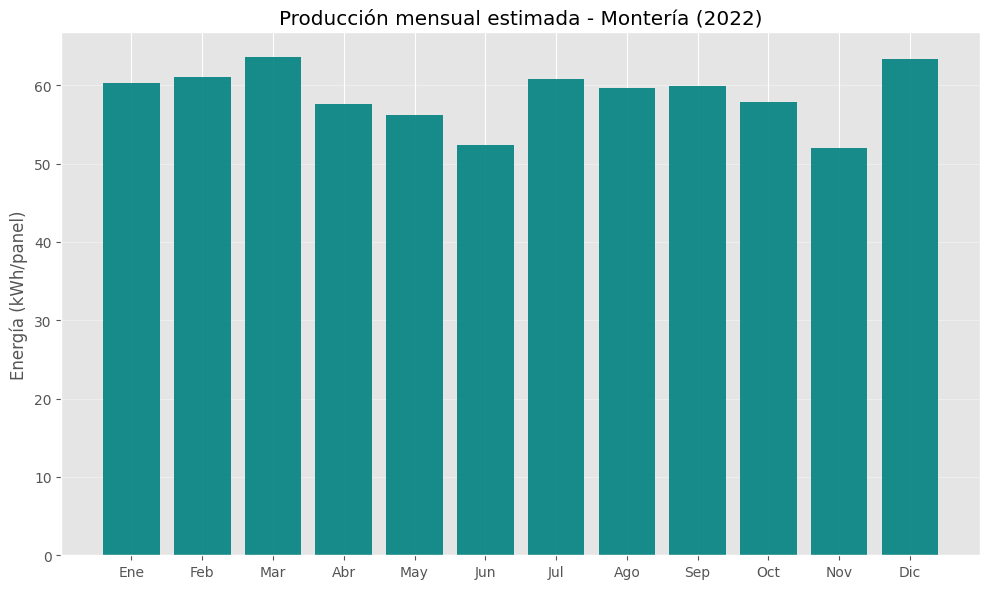

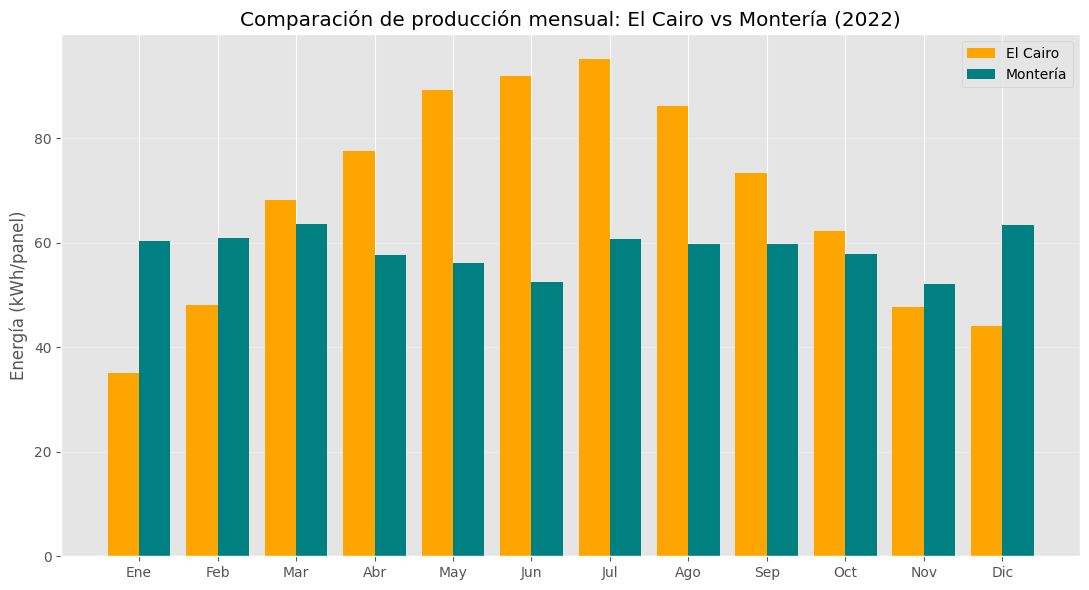


=== TABLA COMPARATIVA FINAL ===
                          Indicador                          El Cairo                          Montería
          GHI promedio anual (W/m²)                            242.87                            212.03
  Energía anual disponible (kWh/m²)                           2127.54                           1857.38
Energía anual producida (kWh/panel)                            818.71                            704.67
      Energía diaria media (kWh/m²)                              5.83                              5.09
           Hora de máxima radiación 2022-07-06 11:30:00 (1042.0 W/m²) 2022-04-22 12:00:00 (1014.0 W/m²)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuración del estilo de gráficos
plt.style.use("ggplot")

# =============================================================================
# CONFIGURACIÓN DEL SISTEMA FOTOVOLTAICO
# =============================================================================
PANEL_AREA = 1.95           # Área del panel en m²
PANEL_EFFICIENCY = 0.20     # Eficiencia del panel (20%)
TEMP_COEFFICIENT = -0.004   # Coeficiente de temperatura (-0.4% por °C)
WIND_COEFFICIENT = 0.002    # Coeficiente de efecto del viento
REFERENCE_TEMP = 25.0       # Temperatura de referencia STC (°C)
TIME_RESOLUTION = 1.0       # Resolución temporal en horas

# =============================================================================
# CARGA Y PREPARACIÓN DE DATOS
# =============================================================================

def load_and_prepare_data(filepath):
    """
    Carga y prepara los datos meteorológicos de un archivo CSV.

    Args:
        filepath (str): Ruta al archivo CSV

    Returns:
        pd.DataFrame: DataFrame con las columnas necesarias procesadas
    """
    # Cargar datos saltando las dos primeras filas (metadata)
    data = pd.read_csv(filepath, skiprows=2)

    # Crear columna de datetime a partir de las columnas individuales
    data['datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour', 'Minute']])

    # Seleccionar solo las columnas necesarias
    required_columns = ['datetime', 'Year', 'Month', 'Day', 'Hour', 'Minute',
                       'GHI', 'Temperature', 'Wind Speed']
    available_columns = [col for col in required_columns if col in data.columns]

    return data[available_columns].copy()

# Cargar datos de ambas ubicaciones
cairo_data = load_and_prepare_data("Cairo_data.csv")
monteria_data = load_and_prepare_data("Monteria_data.csv")

# =============================================================================
# ANÁLISIS DE RADIACIÓN SOLAR
# =============================================================================

class SolarRadiationAnalyzer:
    """Analiza la radiación solar y calcula estadísticas energéticas."""

    def __init__(self, time_resolution=TIME_RESOLUTION):
        self.time_resolution = time_resolution

    def analyze_location(self, data, location_name):
        """
        Analiza completamente los datos de radiación de una ubicación.

        Args:
            data (pd.DataFrame): Datos meteorológicos
            location_name (str): Nombre de la ubicación para referencia

        Returns:
            dict: Diccionario con todos los resultados del análisis
        """
        results = {}
        ghi_values = data['GHI'].to_numpy(dtype=float)

        # Preparar datos auxiliares para agrupamiento
        data_processed = data.copy()
        data_processed['date'] = data_processed['datetime'].dt.date
        data_processed['month'] = data_processed['datetime'].dt.month
        data_processed['hour_decimal'] = (data_processed['datetime'].dt.hour +
                                         data_processed['datetime'].dt.minute / 60.0)

        # Cálculo de energía en diferentes escalas temporales
        results.update(self._calculate_energy_metrics(ghi_values, data_processed))

        # Cálculo de promedios de radiación
        results.update(self._calculate_radiation_averages(ghi_values, data_processed))

        # Identificación de valores extremos
        results.update(self._find_extreme_values(ghi_values, data_processed))

        # Perfil horario promedio
        results['hourly_profile'] = data_processed.groupby('hour_decimal')['GHI'].mean()

        return results

    def _calculate_energy_metrics(self, ghi_values, data_processed):
        """Calcula métricas de energía en diferentes escalas temporales."""
        # Energía por registro individual (Wh/m²)
        energy_per_record = ghi_values * self.time_resolution

        # Energía diaria (agrupada por fecha)
        daily_energy = (data_processed.groupby('date')['GHI']
                       .apply(lambda x: (x.to_numpy(dtype=float) * self.time_resolution).sum()))

        # Energía mensual (agrupada por mes)
        monthly_energy = (data_processed.groupby('month')['GHI']
                         .apply(lambda x: (x.to_numpy(dtype=float) * self.time_resolution).sum())
                         .reindex(range(1, 13), fill_value=0.0))

        # Energía anual total
        annual_energy = daily_energy.sum()

        return {
            'daily_energy_wh_m2': daily_energy,
            'monthly_energy_wh_m2': monthly_energy,
            'annual_energy_wh_m2': annual_energy
        }

    def _calculate_radiation_averages(self, ghi_values, data_processed):
        """Calcula promedios de radiación en diferentes escalas temporales."""
        # Promedio diario de GHI
        daily_avg_ghi = data_processed.groupby('date')['GHI'].mean().to_numpy()

        # Promedio mensual de GHI
        monthly_avg_ghi = (data_processed.groupby('month')['GHI'].mean()
                          .reindex(range(1, 13), fill_value=np.nan).to_numpy())

        # Promedio anual de GHI
        annual_avg_ghi = np.nanmean(ghi_values)

        return {
            'daily_avg_ghi_w_m2': np.nanmean(daily_avg_ghi),
            'monthly_avg_ghi_w_m2': monthly_avg_ghi,
            'annual_avg_ghi_w_m2': annual_avg_ghi
        }

    def _find_extreme_values(self, ghi_values, data_processed):
        """Identifica los valores máximos y mínimos de radiación."""
        if np.all(np.isnan(ghi_values)):
            return {
                'max_radiation_time': None,
                'min_radiation_time': None,
                'max_radiation_value': np.nan,
                'min_radiation_value': np.nan
            }

        max_index = int(np.nanargmax(ghi_values))
        min_index = int(np.nanargmin(ghi_values))

        max_row = data_processed.iloc[max_index]
        min_row = data_processed.iloc[min_index]

        return {
            'max_radiation_time': max_row['datetime'],
            'min_radiation_time': min_row['datetime'],
            'max_radiation_value': ghi_values[max_index],
            'min_radiation_value': ghi_values[min_index]
        }

# Realizar análisis para ambas ubicaciones
analyzer = SolarRadiationAnalyzer()
cairo_analysis = analyzer.analyze_location(cairo_data, "El Cairo")
monteria_analysis = analyzer.analyze_location(monteria_data, "Montería")

# =============================================================================
# PRESENTACIÓN DE RESULTADOS
# =============================================================================

def print_analysis_summary(analysis_results, location_name):
    """Imprime un resumen completo del análisis de una ubicación."""
    print("\n" + "="*70)
    print(f"RESUMEN: {location_name}")
    print("="*70)

    # Estadísticas de radiación
    print("RADIACIÓN SOLAR:")
    print(f"  • Promedio diario: {analysis_results['daily_avg_ghi_w_m2']:.2f} W/m²")
    print(f"  • Promedio mensual: {np.nanmean(analysis_results['monthly_avg_ghi_w_m2']):.2f} W/m²")
    print(f"  • Promedio anual: {analysis_results['annual_avg_ghi_w_m2']:.2f} W/m²")

    # Valores extremos
    if analysis_results['max_radiation_time'] is not None:
        print("\nVALORES EXTREMOS:")
        print(f"  • Máxima radiación: {analysis_results['max_radiation_time']} -> "
              f"{analysis_results['max_radiation_value']:.1f} W/m²")
        print(f"  • Mínima radiación: {analysis_results['min_radiation_time']} -> "
              f"{analysis_results['min_radiation_value']:.1f} W/m²")

    # Energía disponible
    annual_kwh = analysis_results['annual_energy_wh_m2'] / 1000
    daily_avg = np.mean(analysis_results['daily_energy_wh_m2'])

    print("\nENERGÍA DISPONIBLE:")
    print(f"  • Anual: {analysis_results['annual_energy_wh_m2']:.0f} Wh/m² ({annual_kwh:.1f} kWh/m²)")
    print(f"  • Diaria promedio: {daily_avg:.0f} Wh/m²")
    print(f"  • Diaria máxima: {analysis_results['daily_energy_wh_m2'].max():.0f} Wh/m²")
    print(f"  • Diaria mínima: {analysis_results['daily_energy_wh_m2'].min():.0f} Wh/m²")

    # Variación estacional mensual
    print("\nVARIACIÓN ESTACIONAL MENSUAL:")
    monthly_stats = pd.DataFrame({
        'Mes': ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'],
        'GHI_promedio (W/m²)': np.round(analysis_results['monthly_avg_ghi_w_m2'], 2),
        'Energía_mes (kWh/m²)': np.round(analysis_results['monthly_energy_wh_m2'].values / 1000.0, 2)
    })
    print(monthly_stats.to_string(index=False))
    print("="*70)

# Imprimir resúmenes
print_analysis_summary(cairo_analysis, "El Cairo (2022)")
print_analysis_summary(monteria_analysis, "Montería (2022)")

# =============================================================================
# MODELADO DEL PANEL FOTOVOLTAICO
# =============================================================================

class SolarPanelModel:
    """Modela el comportamiento y producción de un panel solar."""

    def __init__(self, area=PANEL_AREA, efficiency=PANEL_EFFICIENCY,
                 temp_coeff=TEMP_COEFFICIENT, wind_coeff=WIND_COEFFICIENT,
                 ref_temp=REFERENCE_TEMP, time_res=TIME_RESOLUTION):

        self.area = area
        self.efficiency = efficiency
        self.temp_coeff = temp_coeff
        self.wind_coeff = wind_coeff
        self.ref_temp = ref_temp
        self.time_resolution = time_res

    def calculate_instant_power(self, irradiance, temperature, wind_speed):
        """
        Calcula la potencia instantánea del panel.

        Args:
            irradiance (array): Radiación solar en W/m²
            temperature (array): Temperatura ambiente en °C
            wind_speed (array): Velocidad del viento en m/s

        Returns:
            array: Potencia en Watts
        """
        irradiance = np.array(irradiance, dtype=float)
        temperature = np.array(temperature, dtype=float)
        wind_speed = np.array(wind_speed, dtype=float)

        # Factor de corrección por temperatura
        temp_factor = 1.0 + self.temp_coeff * (temperature - self.ref_temp)

        # Factor de corrección por viento (limitar efecto máximo)
        wind_factor = 1.0 + self.wind_coeff * (wind_speed - 1.0)
        wind_factor = np.maximum(wind_factor, 0.9)  # Límite del 10% de mejora

        # Cálculo de potencia instantánea
        instant_power = (irradiance * self.area * self.efficiency *
                        temp_factor * wind_factor)

        return instant_power

    def calculate_energy_production(self, meteorological_data):
        """
        Calcula la producción energética total y por periodo.

        Args:
            meteorological_data (pd.DataFrame): Datos meteorológicos

        Returns:
            tuple: (Energía diaria, Energía mensual, Energía total)
        """
        ghi = meteorological_data['GHI'].to_numpy(dtype=float)

        # Usar valores por defecto si no hay datos de temperatura o viento
        temperature = (meteorological_data['Temperature'].to_numpy(dtype=float)
                      if 'Temperature' in meteorological_data.columns
                      else np.full_like(ghi, self.ref_temp))

        wind_speed = (meteorological_data['Wind Speed'].to_numpy(dtype=float)
                     if 'Wind Speed' in meteorological_data.columns
                     else np.ones_like(ghi))

        # Calcular potencia instantánea
        instant_power = self.calculate_instant_power(ghi, temperature, wind_speed)

        # Calcular energía por registro
        energy_per_record = instant_power * self.time_resolution
        total_energy = energy_per_record.sum()

        # Agrupar por periodos
        data_with_energy = meteorological_data.copy()
        data_with_energy['energy_wh'] = energy_per_record
        data_with_energy['date'] = data_with_energy['datetime'].dt.date
        data_with_energy['month'] = data_with_energy['datetime'].dt.month

        daily_energy = data_with_energy.groupby('date')['energy_wh'].sum()
        monthly_energy = (data_with_energy.groupby('month')['energy_wh'].sum()
                         .reindex(range(1, 13), fill_value=0.0))

        return daily_energy, monthly_energy, total_energy

# Modelar la producción para ambas ubicaciones
panel_model = SolarPanelModel()

cairo_daily, cairo_monthly, cairo_annual = panel_model.calculate_energy_production(cairo_data)
monteria_daily, monteria_monthly, monteria_annual = panel_model.calculate_energy_production(monteria_data)

# Presentar resultados de producción
print("\n" + "="*70)
print("POTENCIAL ENERGÉTICO - PANEL DE REFERENCIA")
print("="*70)

production_summary = pd.DataFrame({
    'Ubicación': ['El Cairo', 'Montería'],
    'Energía anual (kWh/panel)': [round(cairo_annual/1000, 2), round(monteria_annual/1000, 2)],
    'Energía anual (Wh/panel)': [int(cairo_annual), int(monteria_annual)],
    'Energía diaria promedio (kWh/panel)': [round(cairo_daily.mean()/1000, 2),
                                           round(monteria_daily.mean()/1000, 2)]
})

print(production_summary.to_string(index=False))
print("="*70)

# =============================================================================
# VISUALIZACIÓN DE RESULTADOS
# =============================================================================

def plot_daily_comparison(data, analysis_results, location_name):
    """Grafica la comparación entre día de máxima, mínima y promedio de radiación."""
    daily_energy = analysis_results['daily_energy_wh_m2']

    # Identificar días representativos
    max_energy_day = daily_energy.idxmax()
    min_energy_day = (daily_energy[daily_energy > 0].idxmin()
                     if (daily_energy > 0).any() else daily_energy.idxmin())

    # Preparar datos para plotting
    plot_data = data.copy()
    plot_data['date'] = plot_data['datetime'].dt.date
    plot_data['hour_decimal'] = plot_data['datetime'].dt.hour + plot_data['datetime'].dt.minute/60.0

    # Series temporales para cada día
    max_day_data = plot_data[plot_data['date'] == max_energy_day].set_index('hour_decimal')['GHI']
    min_day_data = plot_data[plot_data['date'] == min_energy_day].set_index('hour_decimal')['GHI']
    avg_profile = analysis_results['hourly_profile']

    # Crear gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(max_day_data.index, max_day_data.values, marker='o',
             label=f"Día de máxima energía ({max_energy_day})", color='orange', linewidth=2)
    plt.plot(min_day_data.index, min_day_data.values, marker='s',
             label=f"Día de mínima energía ({min_energy_day})", color='steelblue', linewidth=1.6)
    plt.plot(avg_profile.index, avg_profile.values, marker='D', linestyle='--',
             label="Perfil horario promedio", color='black')

    plt.title(f"Comparación horaria de GHI - {location_name} (2022)")
    plt.xlabel("Hora del día")
    plt.ylabel("GHI (W/m²)")
    plt.xlim(0, 24)
    plt.grid(alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_monthly_production(monthly_energy_wh, location_name, color):
    """Grafica la producción mensual estimada."""
    months = range(1, 13)
    monthly_kwh = monthly_energy_wh.reindex(range(1, 13), fill_value=0.0) / 1000.0
    month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                   'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

    plt.figure(figsize=(10, 6))
    plt.bar(months, monthly_kwh, color=color, alpha=0.9)
    plt.xticks(months, month_names)
    plt.ylabel("Energía (kWh/panel)")
    plt.title(f"Producción mensual estimada - {location_name} (2022)")
    plt.grid(axis='y', alpha=0.35)
    plt.tight_layout()
    plt.show()

def plot_comparison(cairo_monthly, monteria_monthly):
    """Grafica comparación mensual entre ambas ubicaciones."""
    months = range(1, 13)
    cairo_kwh = cairo_monthly.reindex(range(1, 13), fill_value=0.0) / 1000.0
    monteria_kwh = monteria_monthly.reindex(range(1, 13), fill_value=0.0) / 1000.0
    month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                   'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

    x_pos = np.arange(len(months))
    bar_width = 0.4

    plt.figure(figsize=(11, 6))
    plt.bar(x_pos - bar_width/2, cairo_kwh, bar_width, label='El Cairo', color='orange')
    plt.bar(x_pos + bar_width/2, monteria_kwh, bar_width, label='Montería', color='teal')

    plt.xticks(x_pos, month_names)
    plt.ylabel("Energía (kWh/panel)")
    plt.title("Comparación de producción mensual: El Cairo vs Montería (2022)")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Generar gráficos
plot_daily_comparison(cairo_data, cairo_analysis, "El Cairo")
plot_daily_comparison(monteria_data, monteria_analysis, "Montería")

plot_monthly_production(cairo_monthly, "El Cairo", "orange")
plot_monthly_production(monteria_monthly, "Montería", "teal")

plot_comparison(cairo_monthly, monteria_monthly)

# =============================================================================
# TABLA COMPARATIVA FINAL
# =============================================================================

final_comparison = pd.DataFrame({
    'Indicador': [
        'GHI promedio anual (W/m²)',
        'Energía anual disponible (kWh/m²)',
        'Energía anual producida (kWh/panel)',
        'Energía diaria media (kWh/m²)',
        'Hora de máxima radiación'
    ],
    'El Cairo': [
        f"{cairo_analysis['annual_avg_ghi_w_m2']:.2f}",
        f"{cairo_analysis['annual_energy_wh_m2']/1000:.2f}",
        f"{cairo_annual/1000:.2f}",
        f"{np.mean(cairo_analysis['daily_energy_wh_m2'])/1000:.2f}",
        f"{cairo_analysis['max_radiation_time']} ({cairo_analysis['max_radiation_value']:.1f} W/m²)"
    ],
    'Montería': [
        f"{monteria_analysis['annual_avg_ghi_w_m2']:.2f}",
        f"{monteria_analysis['annual_energy_wh_m2']/1000:.2f}",
        f"{monteria_annual/1000:.2f}",
        f"{np.mean(monteria_analysis['daily_energy_wh_m2'])/1000:.2f}",
        f"{monteria_analysis['max_radiation_time']} ({monteria_analysis['max_radiation_value']:.1f} W/m²)"
    ]
})

print("\n=== TABLA COMPARATIVA FINAL ===")
print(final_comparison.to_string(index=False))